In [1]:
import requests
import json
import pickle

import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

In [2]:
with open("../secrets/ns_api_key.txt") as f:
    api_key = f.readline()

In [3]:
url = "https://gateway.apiportal.ns.nl/nsapp-stations/v3"
params = {
    "includeNonPlannableStations": "false",
    "countryCodes": "NL"  # Use the correct format for the API
}

headers = {
    'Cache-Control': 'no-cache',
    'Ocp-Apim-Subscription-Key': api_key,
}
reload = False

if reload:
    try:
        response = requests.get(url, headers=headers, params=params)
        response.raise_for_status()  # Raises an HTTPError if the HTTP request returned an unsuccessful status code
        
        response_dict = response.json()  # Parse the JSON response to a dictionary
        print(response.status_code)
        print(json.dumps(response_dict, indent=2))  # Pretty print the JSON response
    
    except requests.exceptions.HTTPError as http_err:
        print(f'HTTP error occurred: {http_err}')
        response_dict = None
    except Exception as err:
        print(f'Other error occurred: {err}')
        response_dict = None

    # Filter entries where country is "NL"
    filtered_payload = [entry for entry in response_dict['payload'] if entry['country'] == 'NL']
    
    # Create a DataFrame from the filtered data
    df = pd.DataFrame(filtered_payload)
    
    # Create a GeoDataFrame
    geometry = [Point(entry['location']['lng'], entry['location']['lat']) for entry in filtered_payload]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')
    # Convert to EPSG:3857
    gdf = gdf.to_crs('EPSG:3857')
    
    # Save the GeoDataFrame as pickle file
    gdf.to_pickle('ns_stations.pkl')
else:
    # Open the pickle
    gdf = pd.read_pickle('ns_stations.pkl')

# Add a column with the ns code
gdf['ns_code'] = [entry['code'] for entry in gdf['id']]
# Add a column with the medium name
gdf['name'] = [entry['long'] for entry in gdf['names']]
    
gdf.head()

id            stationType  \
0  {'uicCode': '8400045', 'evaCode': '8400045', '...    LOCAL_TRAIN_STATION   
1  {'uicCode': '8400047', 'evaCode': '8400047', '...    LOCAL_TRAIN_STATION   
2  {'uicCode': '8400049', 'evaCode': '8400049', '...    LOCAL_TRAIN_STATION   
3  {'uicCode': '8400050', 'evaCode': '8400050', '...  INTERCITY_HUB_STATION   
4  {'uicCode': '8400051', 'evaCode': '8400051', '...  INTERCITY_HUB_STATION   

                                               names  \
0  {'long': 'Aalten', 'medium': 'Aalten', 'short'...   
1  {'long': 'Abcoude', 'medium': 'Abcoude', 'shor...   
2  {'long': 'Akkrum', 'medium': 'Akkrum', 'short'...   
3  {'long': 'Alkmaar', 'medium': 'Alkmaar', 'shor...   
4  {'long': 'Almelo', 'medium': 'Almelo', 'short'...   

                                            location  \
0  {'lat': 51.9213265245505, 'lng': 6.57862722873...   
1                     {'lat': 52.2785, 'lng': 4.977}   
2  {'lat': 53.0463905334473, 'lng': 5.84361124038...   
3  {'lat': 52.6377792358398, 'lng': 4.73972225189...   
4  {'lat': 52.3580551147461, 'lng': 6.65388870239...   

                       tracks  hasKnownFacilities  \
0                      [1, 2]                True   
1                      [2, 3]                True   
2                      [2, 3]                True   
3             [1, 2, 3, 4, 5]                True   
4  [2, 2a, 2b, 3b, 4, 4a, 4b]                True   

   availableForAccessibleTravel  hasTravelAssistance  \
0                          True                 True   
1                          True                 True   
2                          True                 True   
3                          True                 True   
4                          True                 True   

   areTracksIndependentlyAccessible  isBorderStop country  radius  \
0                              True         False      NL     200   
1                              True         False      NL     200   
2                             False         False      NL     200   
3                              True         False      NL     525   
4                              True         False      NL     525   

   approachingRadius   startDate                     nearbyMeLocationId  \
0               1200  2020-05-13  {'value': 'ATN', 'type': 'stationV3'}   
1               1200  2011-05-01   {'value': 'AC', 'type': 'stationV3'}   
2               1600  2023-12-10  {'value': 'AKM', 'type': 'stationV3'}   
3               1200  2003-07-01  {'value': 'AMR', 'type': 'stationV3'}   
4               1200  2023-12-10  {'value': 'AML', 'type': 'stationV3'}   

                         geometry ns_code     name  
0  POINT (732329.433 6785912.762)     ATN   Aalten  
1  POINT (554037.106 6850639.324)      AC  Abcoude  
2  POINT (650507.828 6991583.528)     AKM   Akkrum  
3  POINT (527623.468 6916275.932)     AMR  Alkmaar  
4  POINT (740707.502 6865127.147)     AML   Almelo

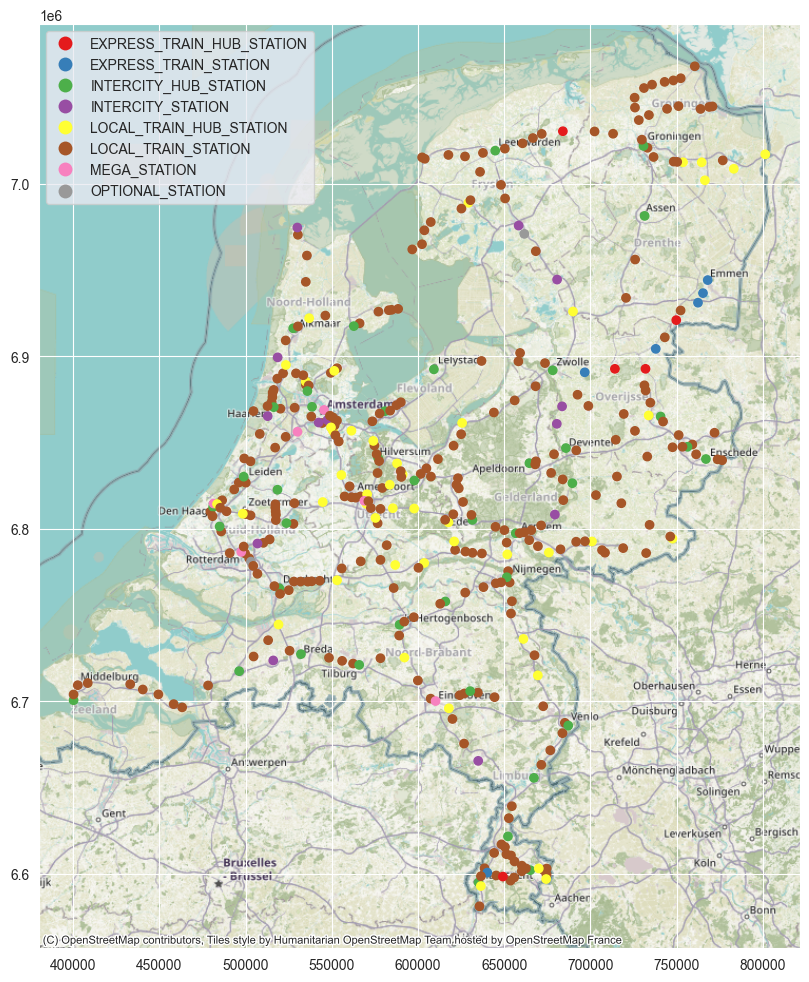

In [4]:
# Add a background map with contextily
import contextily as ctx
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 12))
gdf.plot(ax=ax, column='stationType', legend=True, cmap='Set1')
ctx.add_basemap(ax)
plt.show()

In [5]:
# Print the count of the stationTypes
gdf['stationType'].value_counts()

stationType
LOCAL_TRAIN_STATION          279
LOCAL_TRAIN_HUB_STATION       46
INTERCITY_HUB_STATION         40
INTERCITY_STATION             13
MEGA_STATION                   6
EXPRESS_TRAIN_STATION          6
EXPRESS_TRAIN_HUB_STATION      5
OPTIONAL_STATION               2
Name: count, dtype: int64

### Filter the data to the specific region

In [6]:
# Load ../v_mrdh/areas_65.pkl as geodataframe
areas65 = pd.read_pickle('../v_mrdh/areas_65.pkl')
areas65.head()

geometry  \
65x65 Nummer                                                      
1             MULTIPOLYGON (((91572.39 435285.08, 91571.6 43...   
2             POLYGON ((89429 435269.999, 89384 435277.999, ...   
3             POLYGON ((89677.053 437491.512, 89672.17 43749...   
4             POLYGON ((93801.859 437558.61, 93800.797 43756...   
5             POLYGON ((94944.584 431561.346, 94944.374 4315...   

                     65x65 Naam           GEBIEDEN  WONINGEN_A  INWONERS_A  \
65x65 Nummer                                                                 
1             Rotterdam Centrum  studiegebied RVMK       21529       36209   
2                    Delfshaven  studiegebied RVMK       39740       77508   
3                         Noord  studiegebied RVMK       29516       52490   
4                     Kralingen  studiegebied RVMK       30714       53939   
5              IJsselmonde (bi)  studiegebied RVMK       22324       45467   

              ARBEIDSPL_  LLP12EO_AR  LLP0011_AR  PARKEER_TA  AUTOSPERHH  ...  \
65x65 Nummer                                                              ...   
1                  88158       37649        2213        4.14       0.495  ...   
2                  17468        9165        6332        1.76       0.460  ...   
3                  12453       10649        2807        1.76       0.425  ...   
4                  25025       36520        4257        1.76       0.480  ...   
5                  16658        4404        3906        0.00       0.650  ...   

              1: woningen 2: inwoners  3: inwon0034  4: bbv  5: llp12eo  \
65x65 Nummer                                                              
1                   21529       36209         18948   16284       37649   
2                   39740       77508         41160   30429        9165   
3                   29516       52490         27808   23956       10649   
4                   30714       53939         28785   19379       36520   
5                   22324       45467         19990   16927        4404   

              6: detail  7: industrie  8: rest  9: arbeidspl_totaal  \
65x65 Nummer                                                          
1                  9151          7019    71988                88158   
2                  3430          1068    12970                17468   
3                  3235           499     8719                12453   
4                  2758          4634    17633                25025   
5                  2587          1931    12140                16658   

              10: gebiedstype  
65x65 Nummer                   
1                           1  
2                           1  
3                           1  
4                           1  
5                           1  

[5 rows x 22 columns]

['studiegebied RVMK' 'studiegebied VMH' 'Invloedsgebied'
 'Invloedsgebied verfijnd vmh' 'Invloedsgebied verfijnd'
 'Buitengebied obv LMS' 'Buitengebied obv COROP']


<Axes: >

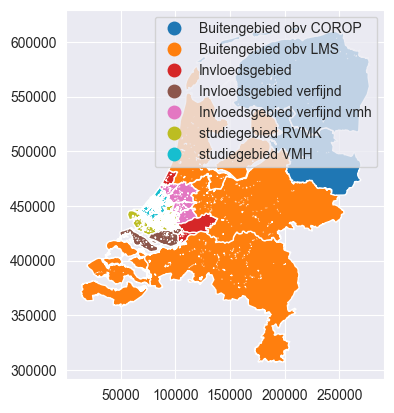

In [7]:
# Print the unique values of the GEBIEDEN column
print(areas65['GEBIEDEN'].unique())
areas65.plot(column='GEBIEDEN', legend=True)

In [8]:
studiegebieden = ['studiegebied RVMK','studiegebied VMH']
invloedsgebieden = ['Invloedsgebied', 'Invloedsgebied verfijnd vmh', 'Invloedsgebied verfijnd']
buitengebiedenen = ['Buitengebied obv LMS', 'Buitengebied obv COROP']

urban = areas65[areas65['GEBIEDEN'].isin(studiegebieden)]
invloedsgebied = areas65[areas65['GEBIEDEN'].isin(invloedsgebieden)]
buitengebied = areas65[areas65['GEBIEDEN'].isin(buitengebiedenen)]

In [9]:
stations_types_invloeds = ['INTERCITY_HUB_STATION', 'INTERCITY_STATION', 'MEGA_STATION', 'LOCAL_TRAIN_HUB_STATION']
stations_types_buitengebied = ['INTERCITY_HUB_STATION', 'INTERCITY_STATION', 'MEGA_STATION']

In [10]:
# Select all the stations in the urban area, invloedsgebied and buitengebied
urban_stations = gpd.sjoin(gdf.to_crs(epsg=28992), urban, predicate='within')

invloeds_stations = gdf[gdf['stationType'].isin(stations_types_invloeds)]
invloeds_stations = gpd.sjoin(invloeds_stations.to_crs(epsg=28992), invloedsgebied, predicate='within')

buitengebied_stations = gdf[gdf['stationType'].isin(stations_types_buitengebied)]
buitengebied_stations = gpd.sjoin(buitengebied_stations.to_crs(epsg=28992), buitengebied, predicate='within')

print(f"Urban stations: {len(urban_stations)}\nInvloeds stations: {len(invloeds_stations)}\nBuitengebied stations: {len(buitengebied_stations)}")

Urban stations: 23
Invloeds stations: 5
Buitengebied stations: 50


In [11]:
# Save the GeoDataFrames as pickle files
urban_stations.to_pickle('urban_stations.pkl')
invloeds_stations.to_pickle('invloeds_stations.pkl')
buitengebied_stations.to_pickle('buitengebied_stations.pkl')

### Travel times

In [12]:
from datetime import datetime

time = datetime(2024, 6, 27, 8, 0, 0)
print(time)

2024-06-27 08:00:00


In [13]:
# Each value in the 'id' column is a dictionary, so we need to extract the 'code' key from each dictionary
urban_ns_codes = [entry['code'] for entry in urban_stations['id']]
invloeds_ns_codes = [entry['code'] for entry in invloeds_stations['id']]
buitengebied_ns_codes = [entry['code'] for entry in buitengebied_stations['id']]

In [14]:
# Add a column with ns codes
urban_stations['ns_code'] = urban_ns_codes
invloeds_stations['ns_code'] = invloeds_ns_codes
buitengebied_stations['ns_code'] = buitengebied_ns_codes

In [15]:
# List of stations (first 3)
stations = urban_ns_codes + invloeds_ns_codes

In [16]:
# NS API Endpoint and your API key
api_endpoint = "https://gateway.apiportal.ns.nl/reisinformatie-api/api/v3/trips"

# Function to get travel time between two stations
def get_trips_data(from_station, to_station):
    params = {
        'fromStation': from_station,
        'toStation': to_station,
        # RFC3339
        'dateTime': time.isoformat(),
    }
    headers = {
        'Ocp-Apim-Subscription-Key': api_key,
    }
    response = requests.get(api_endpoint, params=params, headers=headers)
    data = response.json()
    if data['trips']:
        # Return the start and end time of the trip for each trip (list of tuples)
        return data['trips']
    else:
        return None

In [17]:
# Delft to Alphen aan den Rijn
dd = get_trips_data('DT', 'APN')
# dd[0]

In [18]:
reload2 = False
if reload2:
    # Initialize an empty DataFrame to store the travel time matrix
    trip_dict = {}

    # Populate the travel time matrix
    print(f"Getting travel times for {len(stations)} stations")
    for from_station in stations:
        print(f"Getting travel times from station {from_station}")
        for to_station in stations:
            if from_station != to_station and not (from_station in invloeds_ns_codes and to_station in invloeds_ns_codes):
                trips_data = get_trips_data(from_station, to_station)
                if trips_data:
                    l = trip_dict[(from_station, to_station)] = []
                    for i, trip in enumerate(trips_data):
                        l.append(d:={})
                        d["departure"] = trip['legs'][0]['origin']['plannedDateTime']
                        d["arrival"] = trip['legs'][-1]['destination']['plannedDateTime']
                        d["duration"] = trip['plannedDurationInMinutes']
                        d["transfers"] = trip['transfers']
                    # Print the minimum travel time and transfers from l
                    print(f"{from_station} to {to_station}: >= {min(l, key=lambda x: x['duration'])['duration']} min")
                else:
                    print(f"No trips found from {from_station} to {to_station}")

        # Save the trip_dict as pickle file after each station
        with open('trip_dict.pkl', 'wb') as f:
            pickle.dump(trip_dict, f)
else:
    # Open the pickle
    with open('trip_dict.pkl', 'rb') as f:
        trip_dict = pickle.load(f)

In [19]:
# Create a dicts mapping ns codes to station names
ns_code_to_name = {entry['ns_code']: entry['name'] for entry in gdf.to_dict(orient='records')}
station_names = [ns_code_to_name[station] for station in stations]

In [20]:
# Create a dataframe of the minimal travel time between stations
min_matrix = pd.DataFrame(index=stations, columns=stations, dtype=int)

for (o, d), l in trip_dict.items():
    min_matrix.loc[o, d] = min(l, key=lambda x: x['duration'])['duration']

min_matrix_named = min_matrix.copy()
min_matrix_named.index = station_names
min_matrix_named.columns = station_names

# Drop Rotterdam Stadion from the index and columns
min_matrix.drop(['RTST', 'GR'], axis=0, inplace=True)
min_matrix.drop(['RTST', 'GR'], axis=1, inplace=True)

# Drop Rotterdam Stadion from the index and columns
min_matrix_named.drop(['Rotterdam Stadion', 'Gorinchem'], axis=0, inplace=True)
min_matrix_named.drop(['Rotterdam Stadion', 'Gorinchem'], axis=1, inplace=True)

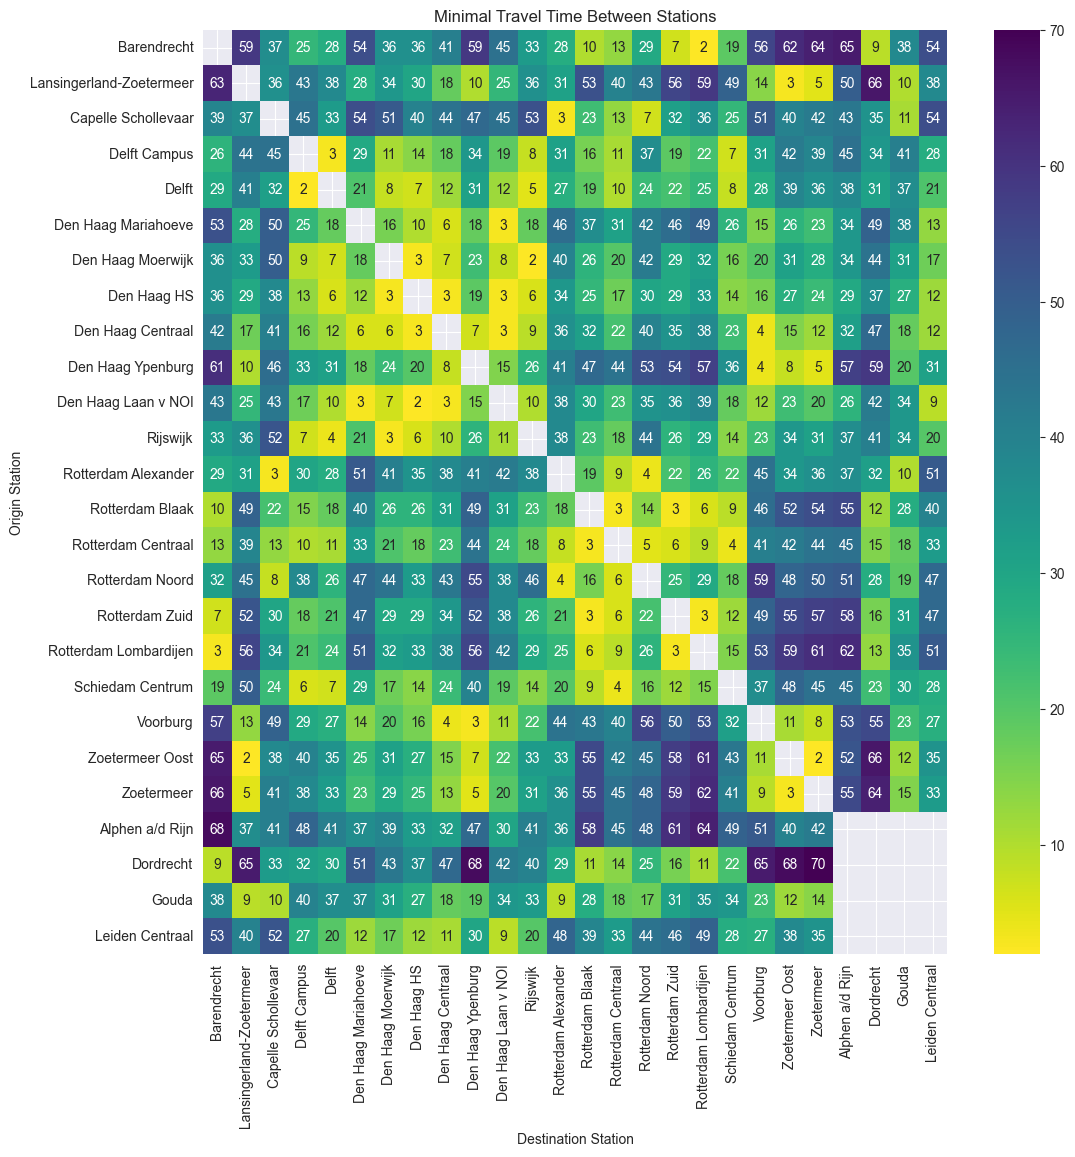

In [21]:
# Ploat a heatmap of the minimal travel time between stations
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(min_matrix_named, ax=ax, cmap='viridis_r', annot=True, fmt=".0f")
# Add title
plt.title("Minimal Travel Time Between Stations")
# Add axis labels
plt.xlabel("Destination Station")
plt.ylabel("Origin Station")
# Save the plot
plt.savefig("img/minimal_travel_time_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

In [22]:
# Create a dataframe of the possible number of transfers between stations
transfers_matrix = pd.DataFrame(index=stations, columns=stations)

for (o, d), l in trip_dict.items():
    transfers_matrix.loc[o, d] = set([trip['transfers'] for trip in l])
transfers_matrix.head()

BRD    LLZM  CPS    DTCP      DT     GVM    GVMW      GV     GVC  \
BRD      NaN  {1, 2}  {1}     {0}  {0, 1}  {1, 2}     {0}  {0, 1}  {0, 1}   
LLZM  {1, 2}     NaN  {1}  {1, 2}  {1, 2}     {1}     {1}  {1, 2}     {0}   
CPS      {1}  {1, 2}  NaN     {1}     {1}     {2}  {1, 2}  {1, 2}  {1, 2}   
DTCP     {0}  {1, 2}  {1}     NaN     {0}     {1}     {0}     {0}     {0}   
DT    {0, 1}  {1, 2}  {1}     {0}     NaN     {1}  {0, 1}     {0}     {0}   

         YPB  ...     RLB     SDM      VB    ZTMO     ZTM     APN     DDR  \
BRD   {1, 2}  ...     {0}  {0, 1}  {1, 2}  {1, 2}  {1, 2}     {2}     {0}   
LLZM     {0}  ...  {1, 2}  {1, 2}     {0}     {0}     {0}     {1}  {1, 2}   
CPS   {1, 2}  ...     {1}     {1}  {1, 2}  {1, 2}  {1, 2}  {1, 2}     {1}   
DTCP     {1}  ...     {0}     {0}     {1}     {1}     {1}     {2}  {0, 1}   
DT       {1}  ...  {0, 1}     {0}     {1}     {1}     {1}  {1, 2}     {0}   

             GR      GD    LEDN  
BRD         {1}     {1}     {1}  
LLZM  {1, 2, 3}     {0}  {1, 2}  
CPS         {2}  {0, 1}     {1}  
DTCP     {1, 2}     {1}     {1}  
DT          {1}     {1}     {0}  

[5 rows x 28 columns]

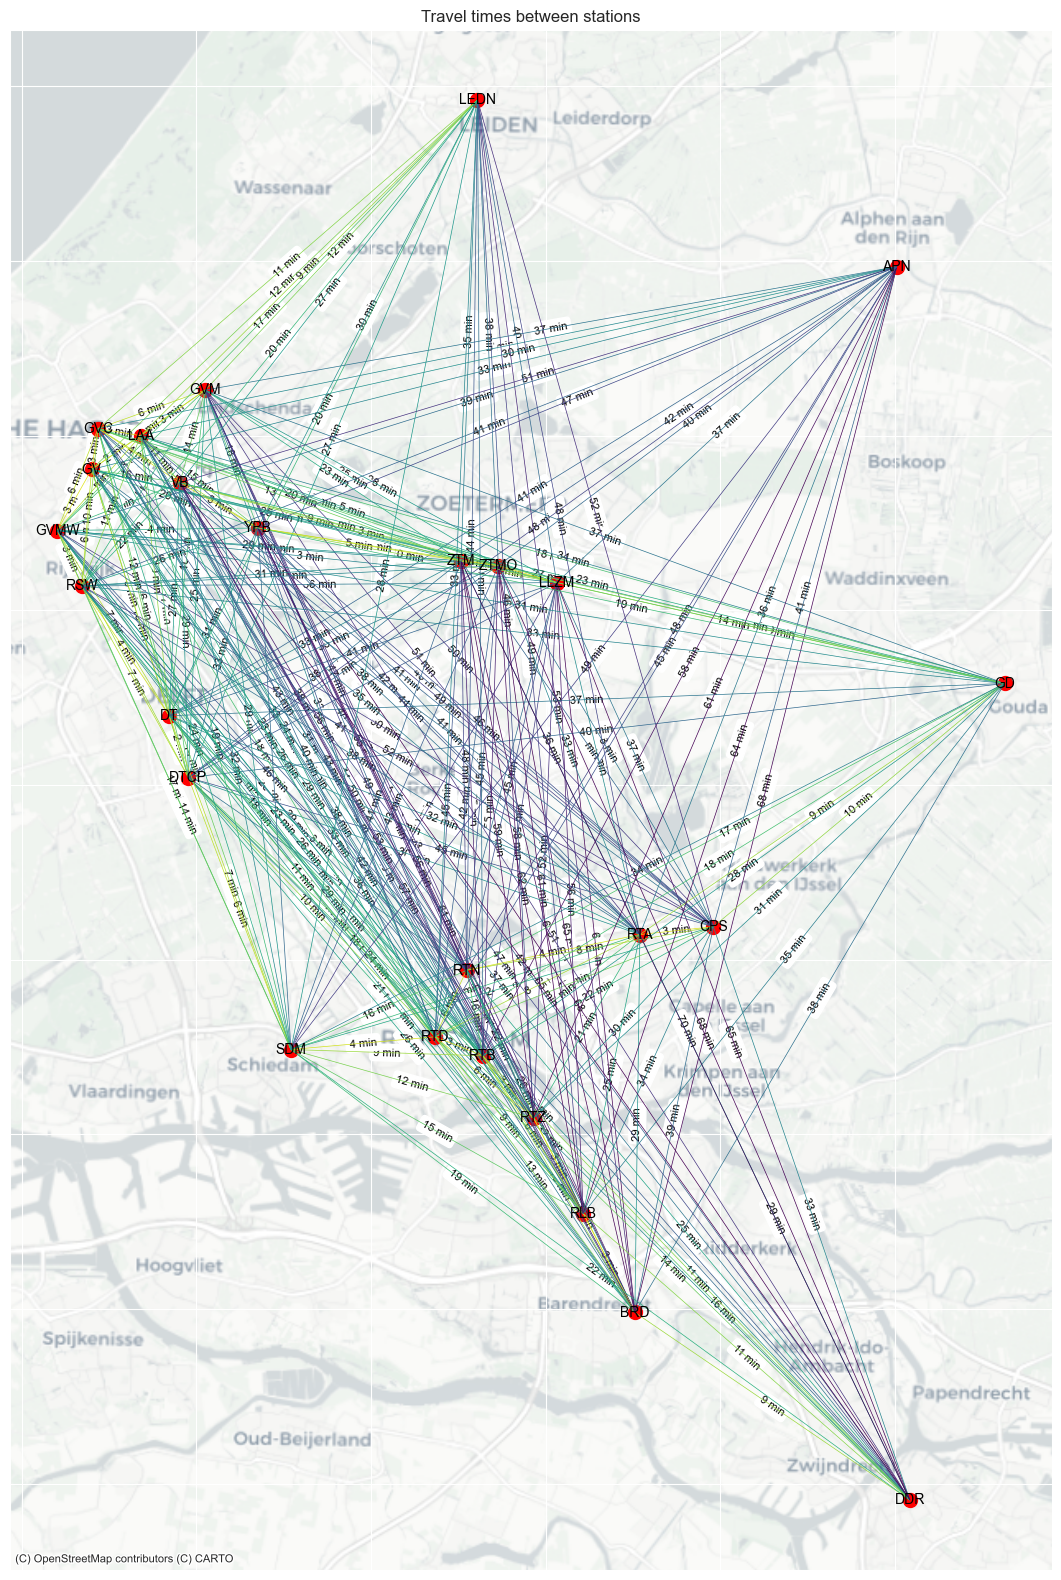

In [23]:
import pandas as pd
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from shapely.geometry import LineString

# Combine the urban and invloeds stations geodataframes
stations_selection = pd.concat([urban_stations, invloeds_stations])

# Drop the Rotterdam Stadion and Gorinchem stations
stations_selection = stations_selection[~stations_selection['ns_code'].isin(['RTST', 'GR'])]

# Create the NetworkX graph
G = nx.Graph()

# Add nodes with coordinates
for index, row in stations_selection.iterrows():
    G.add_node(row['ns_code'], pos=(row.geometry.x, row.geometry.y))

# Add edges with travel times as weights
for i, station1 in enumerate(min_matrix.index):
    for j, station2 in enumerate(min_matrix.columns):
        if station1 != station2 and min_matrix.loc[station1, station2] > 0:
            G.add_edge(station1, station2, weight=min_matrix.loc[station1, station2])

# Plot the map
fig, ax = plt.subplots(figsize=(20, 20))

# Plot the basemap
stations_selection.plot(ax=ax, color='white', edgecolor='black')

# Plot the nodes
positions = nx.get_node_attributes(G, 'pos')
nx.draw_networkx_nodes(G, positions, node_size=100, node_color='red', ax=ax)

# Plot the edges
for u, v, data in G.edges(data=True):
    x1, y1 = positions[u]
    x2, y2 = positions[v]
    line = LineString([(x1, y1), (x2, y2)])
    time = data['weight']
    # Convert the time into a color
    color = plt.cm.viridis_r(time / 60)
    gdf = gpd.GeoDataFrame([{'geometry': line}], crs=stations_selection.crs)
    gdf.plot(ax=ax, linewidth=0.5, edgecolor=color)

# Add edge labels to show travel times
edge_labels = {(u, v): f"{int(d['weight'])} min" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, positions, edge_labels=edge_labels, font_size=8, ax=ax)

# Optionally, add labels
nx.draw_networkx_labels(G, positions, font_size=10, font_color='black', ax=ax)

# Add background map
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs='EPSG:28992')

# Add a title and legend
plt.title("Travel times between stations")
# Save the plot
plt.savefig("img/travel_times_between_stations.png", dpi=300, bbox_inches='tight')

plt.show()